<a href="https://colab.research.google.com/github/MohamadRayi/MachineLearningTasks/blob/main/Clustering_Text_Documents_using_k_means_Rayi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Mohamad Rayi Dwi Putra
NIM : 1103213070
Task 6 Clustering
**Clustering text documents using k-means**

**Loading text data**

In [9]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups

# Definisikan kategori-kategori yang ingin dimuat dari dataset 20newsgroups
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]

# Muat dataset 20newsgroups dengan kategori-kategori yang ditentukan
dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),  # Menghapus bagian tertentu dari data
    subset="all",  # Menggunakan seluruh dataset
    categories=categories,  # Hanya mengambil data dari kategori yang ditentukan
    shuffle=True,  # Mengacak urutan data
    random_state=42,  # Seed untuk reproduktibilitas
)

# Ambil label-label dari dataset
labels = dataset.target

# Hitung jumlah unik label dan ukuran setiap kategori
unique_labels, category_sizes = np.unique(labels, return_counts=True)
true_k = unique_labels.shape[0]

# Cetak informasi tentang dataset
print(f"{len(dataset.data)} documents - {true_k} categories")


3387 documents - 4 categories


**Quantifying the quality of clustering results**

In [10]:
from collections import defaultdict
from time import time
import numpy as np
from sklearn import metrics

# Daftar untuk menyimpan hasil evaluasi
evaluations = []
evaluations_std = []

# Fungsi untuk melatih model dan mengevaluasinya
def fit_and_evaluate(km, X, name=None, n_runs=5):
    # Jika nama tidak ditentukan, gunakan nama kelas estimator
    name = km.__class__.__name__ if name is None else name

    # Daftar untuk menyimpan waktu pelatihan
    train_times = []

    # Dictionary untuk menyimpan skor evaluasi
    scores = defaultdict(list)

    # Lakukan beberapa percobaan pelatihan untuk mendapatkan rata-rata dan standar deviasi
    for seed in range(n_runs):
        km.set_params(random_state=seed)  # Atur seed acak untuk reproduktibilitas
        t0 = time()  # Catat waktu awal
        km.fit(X)  # Latih model
        train_times.append(time() - t0)  # Hitung waktu pelatihan
        # Hitung skor evaluasi
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(labels, km.labels_))
        scores["Silhouette Coefficient"].append(
            metrics.silhouette_score(X, km.labels_, sample_size=2000)
        )
    train_times = np.asarray(train_times)  # Konversi daftar waktu pelatihan ke dalam array numpy

    # Cetak informasi tentang waktu pelatihan dan skor evaluasi
    print(f"clustering done in {train_times.mean():.2f} ± {train_times.std():.2f} s ")
    evaluation = {
        "estimator": name,
        "train_time": train_times.mean(),
    }
    evaluation_std = {
        "estimator": name,
        "train_time": train_times.std(),
    }
    # Iterasi melalui skor evaluasi dan tambahkan ke dalam dictionary hasil evaluasi
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    evaluations.append(evaluation)  # Tambahkan hasil evaluasi ke dalam daftar hasil evaluasi
    evaluations_std.append(evaluation_std)  # Tambahkan hasil evaluasi standar deviasi ke dalam daftar hasil evaluasi

# Untuk mereproduksi kode, Anda memerlukan definisi dataset dan label
# serta model yang akan dievaluasi. Pastikan Anda telah menentukan dataset dan labelnya sebelum menjalankan fungsi ini.
# Sebagai contoh, Anda dapat menggunakan dataset dan label yang diperoleh dari kode sebelumnya.
# Juga, pastikan model (misalnya KMeans) telah didefinisikan sebelumnya.
# Untuk menjalankan fungsi fit_and_evaluate, Anda dapat memanggilnya seperti ini:
# fit_and_evaluate(model, X)


**Feature Extraction using TfidfVectorizer**

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

# Definisikan objek TfidfVectorizer dengan parameter yang sama seperti sebelumnya
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
)

# Catat waktu awal
t0 = time()

# Lakukan vektorisasi pada dataset
X_tfidf = vectorizer.fit_transform(dataset.data)

# Cetak informasi tentang waktu yang diperlukan untuk vektorisasi
print(f"vectorization done in {time() - t0:.3f} s")

# Cetak informasi tentang ukuran dataset hasil vektorisasi
print(f"n_samples: {X_tfidf.shape[0]}, n_features: {X_tfidf.shape[1]}")

# Cetak densitas dari matriks hasil vektorisasi
print(f"{X_tfidf.nnz / np.prod(X_tfidf.shape):.3f}")


vectorization done in 0.671 s
n_samples: 3387, n_features: 7929
0.007


**Clustering sparse data with k-means**

In [12]:
from sklearn.cluster import KMeans

# Lakukan clustering dengan KMeans untuk beberapa seed acak
for seed in range(5):
    kmeans = KMeans(
        n_clusters=true_k,
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X_tfidf)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}")

# Cetak informasi tentang jumlah dokumen sesungguhnya dalam setiap kategori berdasarkan label kelas
print()
print(
    "True number of documents in each category according to the class labels: "
    f"{category_sizes}"
)

# Inisialisasi KMeans untuk evaluasi
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=5,
)

# Evaluasi KMeans menggunakan fungsi yang telah didefinisikan sebelumnya
fit_and_evaluate(kmeans, X_tfidf, name="KMeans\non tf-idf vectors")


Number of elements assigned to each cluster: [   1    1 3384    1]
Number of elements assigned to each cluster: [1597  732  233  825]
Number of elements assigned to each cluster: [2004  446  646  291]
Number of elements assigned to each cluster: [1695  649  446  597]
Number of elements assigned to each cluster: [ 254 2117  459  557]

True number of documents in each category according to the class labels: [799 973 987 628]
clustering done in 0.34 ± 0.18 s 
Homogeneity: 0.336 ± 0.026
Completeness: 0.400 ± 0.008
V-measure: 0.365 ± 0.014
Adjusted Rand-Index: 0.202 ± 0.012
Silhouette Coefficient: 0.008 ± 0.002


**Performing dimensionality reduction using LSA**

In [13]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import MiniBatchKMeans

# Pipeline untuk LSA
lsa = make_pipeline(TruncatedSVD(n_components=100), Normalizer(copy=False))
t0 = time()
X_lsa = lsa.fit_transform(X_tfidf)
explained_variance = lsa[0].explained_variance_ratio_.sum()
print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")

# KMeans dengan LSA
kmeans = KMeans(
    n_clusters=true_k,
    max_iter=100,
    n_init=1,
)
fit_and_evaluate(kmeans, X_lsa, name="KMeans\nwith LSA on tf-idf vectors")

# MiniBatchKMeans dengan LSA
minibatch_kmeans = MiniBatchKMeans(
    n_clusters=true_k,
    n_init=1,
    init_size=1000,
    batch_size=1000,
)
fit_and_evaluate(
    minibatch_kmeans,
    X_lsa,
    name="MiniBatchKMeans\nwith LSA on tf-idf vectors",
)


LSA done in 0.665 s
Explained variance of the SVD step: 18.4%
clustering done in 0.14 ± 0.02 s 
Homogeneity: 0.386 ± 0.027
Completeness: 0.454 ± 0.047
V-measure: 0.416 ± 0.029
Adjusted Rand-Index: 0.314 ± 0.042
Silhouette Coefficient: 0.026 ± 0.008
clustering done in 0.12 ± 0.04 s 
Homogeneity: 0.417 ± 0.012
Completeness: 0.433 ± 0.018
V-measure: 0.425 ± 0.014
Adjusted Rand-Index: 0.390 ± 0.030
Silhouette Coefficient: 0.027 ± 0.002


**Top terms per cluster**

In [14]:
# Mendapatkan pusat klaster kembali ke ruang asli
original_space_centroids = lsa[0].inverse_transform(kmeans.cluster_centers_)
# Mengurutkan indeks pusat klaster
order_centroids = original_space_centroids.argsort()[:, ::-1]
# Mendapatkan daftar kata kunci
terms = vectorizer.get_feature_names_out()

# Cetak kata kunci untuk setiap klaster
for i in range(true_k):
    print(f"Cluster {i}: ", end="")
    for ind in order_centroids[i, :10]:
        print(f"{terms[ind]} ", end="")
    print()


Cluster 0: thanks graphics image file files know program looking help edu 
Cluster 1: god jesus bible believe christian people say faith don christians 
Cluster 2: space nasa launch shuttle station program like sci just earth 
Cluster 3: just think don people like know time say ve way 


**HashingVectorizer**

In [15]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer

# Membuat pipeline untuk hashing vectorizer dan LSA
lsa_vectorizer = make_pipeline(
    HashingVectorizer(stop_words="english", n_features=50_000),
    TfidfTransformer(),
    TruncatedSVD(n_components=100, random_state=0),
    Normalizer(copy=False),
)

# Melakukan vektorisasi dan pemrosesan LSA pada dataset
t0 = time()
X_hashed_lsa = lsa_vectorizer.fit_transform(dataset.data)
print(f"vectorization done in {time() - t0:.3f} s")

# Evaluasi KMeans dengan LSA pada hashed vectors
fit_and_evaluate(kmeans, X_hashed_lsa, name="KMeans\nwith LSA on hashed vectors")

# Evaluasi MiniBatchKMeans dengan LSA pada hashed vectors
fit_and_evaluate(
    minibatch_kmeans,
    X_hashed_lsa,
    name="MiniBatchKMeans\nwith LSA on hashed vectors",
)


vectorization done in 3.095 s
clustering done in 0.13 ± 0.02 s 
Homogeneity: 0.405 ± 0.003
Completeness: 0.456 ± 0.004
V-measure: 0.429 ± 0.003
Adjusted Rand-Index: 0.330 ± 0.008
Silhouette Coefficient: 0.030 ± 0.001
clustering done in 0.14 ± 0.02 s 
Homogeneity: 0.363 ± 0.063
Completeness: 0.375 ± 0.063
V-measure: 0.369 ± 0.062
Adjusted Rand-Index: 0.324 ± 0.067
Silhouette Coefficient: 0.025 ± 0.004


**Clustering evaluation summary**

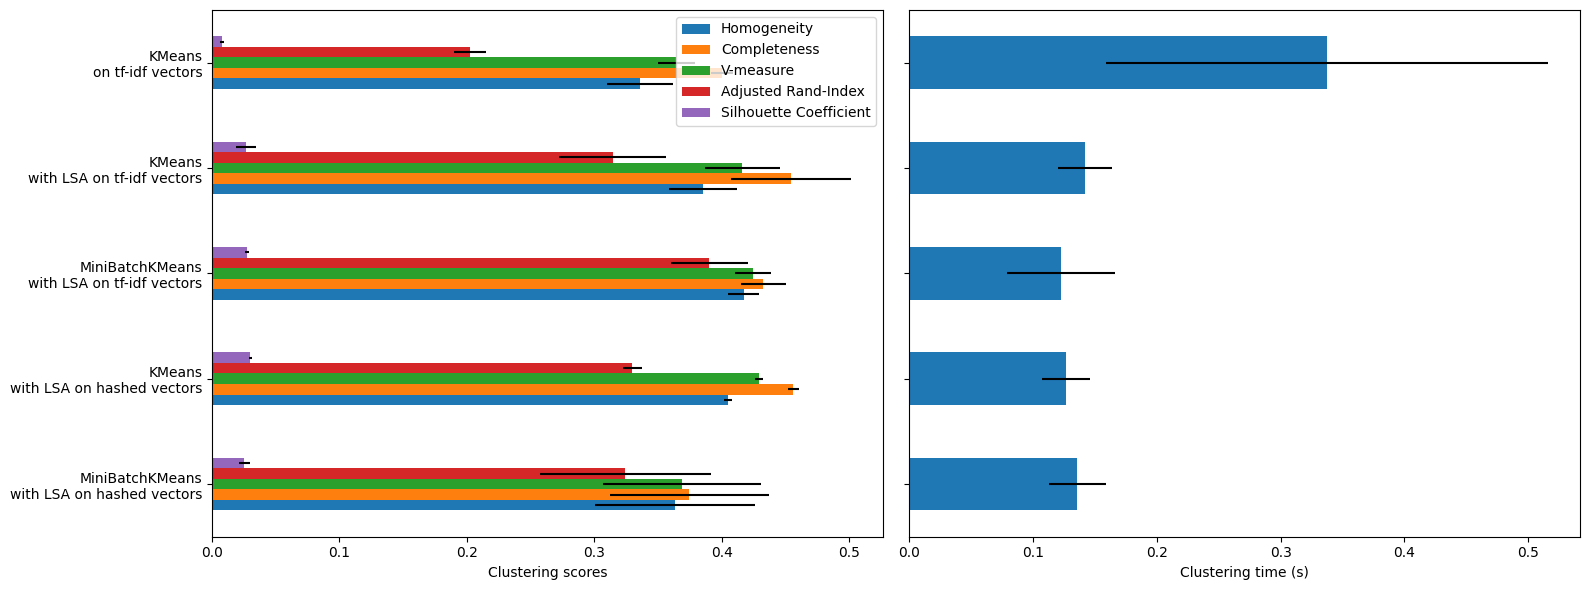

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Membuat subplot dan mengatur ukuran
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 6), sharey=True)

# Membuat dataframe dari hasil evaluasi dan standar deviasi
df = pd.DataFrame(evaluations[::-1]).set_index("estimator")
df_std = pd.DataFrame(evaluations_std[::-1]).set_index("estimator")

# Visualisasi skor evaluasi klaster
df.drop(
    ["train_time"],
    axis="columns",
).plot.barh(ax=ax0, xerr=df_std)
ax0.set_xlabel("Clustering scores")
ax0.set_ylabel("")

# Visualisasi waktu pelatihan klaster
df["train_time"].plot.barh(ax=ax1, xerr=df_std["train_time"])
ax1.set_xlabel("Clustering time (s)")

# Menyesuaikan tata letak
plt.tight_layout()
